In [1]:
import keras
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.layers import Conv2D, Activation,AveragePooling2D
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf


In [2]:
num_classes = 10
epochs = 20

In [3]:
def euclid_dis(vects):
  x,y = vects

  sum_square = K.square(x-y)
  sum_square = K.sum(sum_square, axis = 1, keepdims = True)
  
  sum_square = K.maximum(sum_square , K.epsilon())
  sum_square = K.sqrt(sum_square)
  return sum_square

In [4]:
def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

In [5]:
def contrastive_loss(y_true, y_pred):
  """
  margin = 1
  square_pred = K.square(y_pred)

  margin_square = K.maximum(margin - y_pred,0)
  margin_square = K.square(margin_square)

  ret_mean = (1 - y_true) * margin_square
  ret_mean = ret_mean + (y_true * square_pred)
  ret_mean = K.mean(ret_mean)
  return ret_mean
  """
  #print(type(y_pred))
  #print(type(y_true))

  y_true = tf.cast(y_true, y_pred.dtype)
  margin = 1.0
  square_pred = K.square(y_pred)
  margin_square = K.square(K.maximum(margin - y_pred, 0.0))
  return K.mean((1.0 - y_true) * square_pred +  y_true * margin_square)


In [6]:
def create_pairs(x, digit_indices):
  pairs = []
  labels = []
  
  n=min([len(digit_indices[d]) for d in range(num_classes)]) -1
  
  for d in range(num_classes):
    for i in range(n):
      z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, num_classes)
      dn = (d + inc) % num_classes
      z1, z2 = digit_indices[d][i], digit_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1,0]
  return np.array(pairs), np.array(labels)

In [7]:
def compute_accuracy(y_true, y_pred):
  pred = y_pred.ravel() < 0.5
  return np.mean(pred == y_true)

In [8]:
def accuracy(y_true, y_pred):
  return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [9]:
def create_base_net(input_shape):
  
  input = Input(shape = input_shape)
  x = Conv2D(4, (5,5), activation = 'relu')(input)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Conv2D(16, (5,5), activation = 'relu')(x)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Flatten()(x)
  x = Dense(10, activation = 'tanh')(x)
  model = Model(input, x)
  model.summary()
  
  return model

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train.reshape(x_train.shape[0], 28, 28,1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
"""
x_train /= 255
x_test /= 255

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
"""

x_train = x_train / 255
x_test = x_test / 255

In [ ]:

"""
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
"""

'x_train = np.expand_dims(x_train, axis=-1)\nx_test = np.expand_dims(x_test, axis=-1)\n'

In [ ]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [14]:
input_shape = x_train.shape[1:]
print(input_shape)
input_shape = (28, 28, 1)

(28, 28, 1)


In [ ]:
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [ ]:
print(tr_pairs.shape)
print(tr_y.shape)
print(te_pairs.shape)
print(te_y.shape)

(108400, 2, 28, 28, 1)
(108400,)
(17820, 2, 28, 28, 1)
(17820,)


In [15]:
base_network = create_base_net(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 4)         104       
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 12, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          1616      
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2570  

In [16]:
distance = Lambda(euclid_dis,output_shape=eucl_dist_output_shape)([processed_a, processed_b])

In [17]:
model = Model([input_a, input_b], distance)

In [ ]:
dummy =  tr_pairs[:,0]

print(type(dummy[0][0][0]))

<class 'numpy.ndarray'>


In [ ]:
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=["accuracy"])
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,batch_size=128,epochs=epochs,validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/20
847/847 [==============================] - 37s 5ms/step - loss: 0.3632 - accuracy: 0.4689 - val_loss: 0.3292 - val_accuracy: 0.4441
Epoch 2/20
847/847 [==============================] - 4s 5ms/step - loss: 0.3021 - accuracy: 0.4707 - val_loss: 0.3116 - val_accuracy: 0.4491
Epoch 3/20
847/847 [==============================] - 4s 5ms/step - loss: 0.2913 - accuracy: 0.4794 - val_loss: 0.3059 - val_accuracy: 0.4575
Epoch 4/20
847/847 [==============================] - 4s 5ms/step - loss: 0.2873 - accuracy: 0.4794 - val_loss: 0.3009 - val_accuracy: 0.4507
Epoch 5/20
847/847 [==============================] - 4s 5ms/step - loss: 0.2841 - accuracy: 0.4850 - val_loss: 0.2981 - val_accuracy: 0.4548
Epoch 6/20
847/847 [==============================] - 4s 5ms/step - loss: 0.2824 - accuracy: 0.4854 - val_loss: 0.2963 - val_accuracy: 0.4485
Epoch 7/20
847/847 [==============================] - 4s 5ms/step - loss: 0.2812 - accuracy: 0.4860 - val_loss: 0.2938 - val_accuracy: 0.4513
Epoch

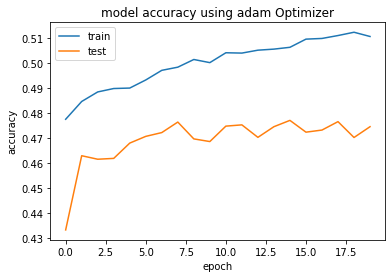

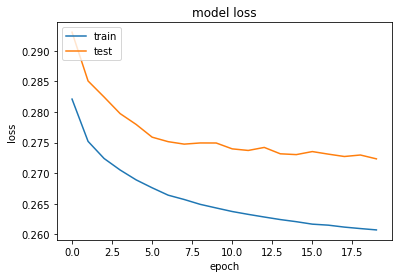

In [ ]:
import matplotlib.pyplot as plt
 
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy using adam Optimizer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
adam = Adam()
model.compile(loss=contrastive_loss, optimizer=adam, metrics=["accuracy"])
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,batch_size=128,epochs=epochs,validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/20
847/847 [==============================] - 5s 5ms/step - loss: 0.2600 - accuracy: 0.5149 - val_loss: 0.2729 - val_accuracy: 0.4730
Epoch 2/20
847/847 [==============================] - 4s 5ms/step - loss: 0.2596 - accuracy: 0.5154 - val_loss: 0.2718 - val_accuracy: 0.4771
Epoch 3/20
847/847 [==============================] - 4s 4ms/step - loss: 0.2587 - accuracy: 0.5176 - val_loss: 0.2721 - val_accuracy: 0.4791
Epoch 4/20
847/847 [==============================] - 4s 4ms/step - loss: 0.2591 - accuracy: 0.5162 - val_loss: 0.2732 - val_accuracy: 0.4792
Epoch 5/20
847/847 [==============================] - 4s 5ms/step - loss: 0.2582 - accuracy: 0.5193 - val_loss: 0.2714 - val_accuracy: 0.4745
Epoch 6/20
847/847 [==============================] - 4s 4ms/step - loss: 0.2580 - accuracy: 0.5189 - val_loss: 0.2723 - val_accuracy: 0.4760
Epoch 7/20
847/847 [==============================] - 4s 4ms/step - loss: 0.2579 - accuracy: 0.5214 - val_loss: 0.2715 - val_accuracy: 0.4779
Epoch 

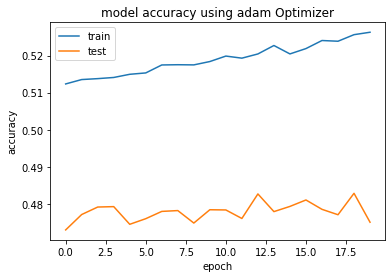

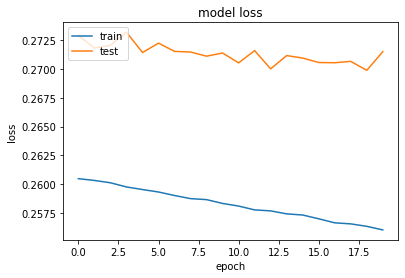

In [ ]:
import matplotlib.pyplot as plt
 
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy using adam Optimizer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
!pip install -q -U tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 706kB 7.9MB/s 


In [ ]:
rms = RMSprop()
triplet_loss = tfa.losses.TripletSemiHardLoss()
model.compile(loss=triplet_loss, optimizer=rms, metrics=["accuracy"])
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,batch_size=128,epochs=epochs,validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/20
847/847 [==============================] - 8s 7ms/step - loss: 0.9798 - accuracy: 0.3918 - val_loss: 0.8673 - val_accuracy: 0.3561
Epoch 2/20
847/847 [==============================] - 6s 7ms/step - loss: 0.9227 - accuracy: 0.3771 - val_loss: 0.8271 - val_accuracy: 0.3679
Epoch 3/20
847/847 [==============================] - 6s 7ms/step - loss: 0.9033 - accuracy: 0.3707 - val_loss: 0.8064 - val_accuracy: 0.3382
Epoch 4/20
847/847 [==============================] - 6s 7ms/step - loss: 0.8913 - accuracy: 0.3410 - val_loss: 0.7894 - val_accuracy: 0.2914
Epoch 5/20
847/847 [==============================] - 6s 7ms/step - loss: 0.8762 - accuracy: 0.3188 - val_loss: 0.7851 - val_accuracy: 0.2904
Epoch 6/20
847/847 [==============================] - 6s 7ms/step - loss: 0.8702 - accuracy: 0.3029 - val_loss: 0.7756 - val_accuracy: 0.2605
Epoch 7/20
847/847 [==============================] - 6s 7ms/step - loss: 0.8635 - accuracy: 0.2973 - val_loss: 0.7667 - val_accuracy: 0.2735
Epoch 

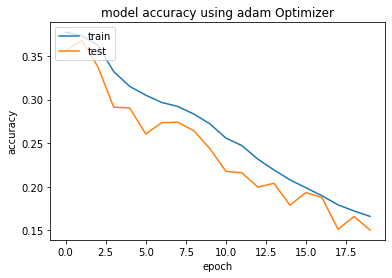

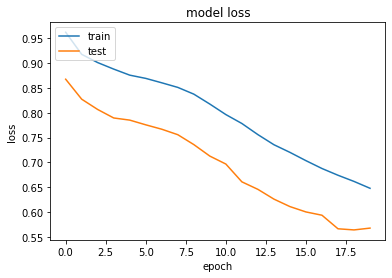

In [ ]:
import matplotlib.pyplot as plt
 
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy using adam Optimizer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
adam = Adam()
triplet_loss = tfa.losses.TripletSemiHardLoss()
model.compile(loss=triplet_loss, optimizer=adam, metrics=["accuracy"])
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,batch_size=128,epochs=epochs,validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/20
847/847 [==============================] - 6s 7ms/step - loss: 0.6446 - accuracy: 0.1605 - val_loss: 0.5389 - val_accuracy: 0.1561
Epoch 2/20
847/847 [==============================] - 6s 7ms/step - loss: 0.6278 - accuracy: 0.1561 - val_loss: 0.5291 - val_accuracy: 0.1403
Epoch 3/20
847/847 [==============================] - 6s 7ms/step - loss: 0.6186 - accuracy: 0.1501 - val_loss: 0.5301 - val_accuracy: 0.1405
Epoch 4/20
847/847 [==============================] - 6s 7ms/step - loss: 0.6068 - accuracy: 0.1451 - val_loss: 0.5067 - val_accuracy: 0.1304
Epoch 5/20
847/847 [==============================] - 6s 7ms/step - loss: 0.5966 - accuracy: 0.1390 - val_loss: 0.4928 - val_accuracy: 0.1206
Epoch 6/20
847/847 [==============================] - 6s 7ms/step - loss: 0.5910 - accuracy: 0.1369 - val_loss: 0.4984 - val_accuracy: 0.1222
Epoch 7/20
847/847 [==============================] - 6s 7ms/step - loss: 0.5819 - accuracy: 0.1356 - val_loss: 0.4998 - val_accuracy: 0.1231
Epoch 

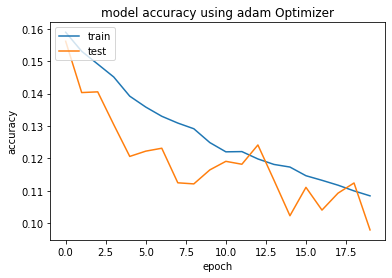

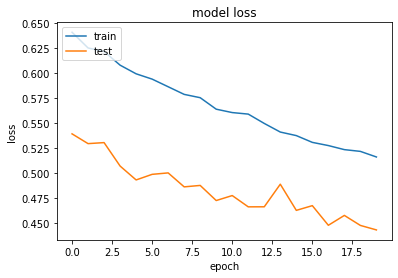

In [ ]:
import matplotlib.pyplot as plt
 
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy using adam Optimizer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
adam = Adam()
#triplet_loss = tfa.losses.TripletSemiHardLoss()
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=["accuracy"])
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,batch_size=128,epochs=epochs,validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/20
847/847 [==============================] - 5s 5ms/step - loss: 5.9172e-08 - accuracy: 0.1001 - val_loss: 5.9605e-08 - val_accuracy: 0.0979
Epoch 2/20
847/847 [==============================] - 4s 5ms/step - loss: 5.9331e-08 - accuracy: 0.1000 - val_loss: 5.9605e-08 - val_accuracy: 0.0979
Epoch 3/20
847/847 [==============================] - 4s 5ms/step - loss: 5.9685e-08 - accuracy: 0.1003 - val_loss: 5.9605e-08 - val_accuracy: 0.0979
Epoch 4/20
847/847 [==============================] - 4s 5ms/step - loss: 5.9546e-08 - accuracy: 0.1011 - val_loss: 5.9605e-08 - val_accuracy: 0.0979
Epoch 5/20
847/847 [==============================] - 4s 5ms/step - loss: 5.9660e-08 - accuracy: 0.1015 - val_loss: 5.9605e-08 - val_accuracy: 0.0979
Epoch 6/20
847/847 [==============================] - 4s 5ms/step - loss: 5.9883e-08 - accuracy: 0.1016 - val_loss: 5.9605e-08 - val_accuracy: 0.0979
Epoch 7/20
847/847 [==============================] - 4s 5ms/step - loss: 5.9405e-08 - accuracy: 0.1

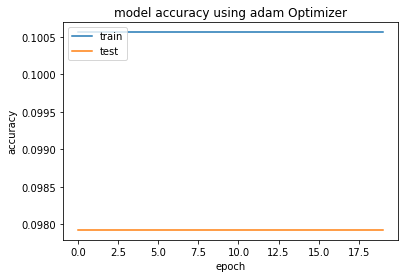

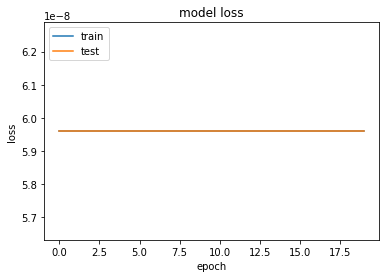

In [ ]:
import matplotlib.pyplot as plt
 
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy using adam Optimizer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
rms = RMSprop(learning_rate= 0.000000001)
#triplet_loss = tfa.losses.TripletSemiHardLoss()
model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=["accuracy"])
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,batch_size=128,epochs=15,validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/15
847/847 [==============================] - 5s 5ms/step - loss: 5.9471e-08 - accuracy: 0.1027 - val_loss: 5.9605e-08 - val_accuracy: 0.0979
Epoch 2/15
847/847 [==============================] - 4s 5ms/step - loss: 5.9533e-08 - accuracy: 0.0998 - val_loss: 5.9605e-08 - val_accuracy: 0.0979
Epoch 3/15
847/847 [==============================] - 4s 5ms/step - loss: 5.9665e-08 - accuracy: 0.1002 - val_loss: 5.9605e-08 - val_accuracy: 0.0979
Epoch 4/15
847/847 [==============================] - 4s 5ms/step - loss: 5.9958e-08 - accuracy: 0.1009 - val_loss: 5.9605e-08 - val_accuracy: 0.0979
Epoch 5/15
847/847 [==============================] - 4s 5ms/step - loss: 5.9644e-08 - accuracy: 0.1007 - val_loss: 5.9605e-08 - val_accuracy: 0.0979
Epoch 6/15
847/847 [==============================] - 4s 5ms/step - loss: 5.9804e-08 - accuracy: 0.1004 - val_loss: 5.9605e-08 - val_accuracy: 0.0979
Epoch 7/15
847/847 [==============================] - 4s 5ms/step - loss: 5.9509e-08 - accuracy: 0.1

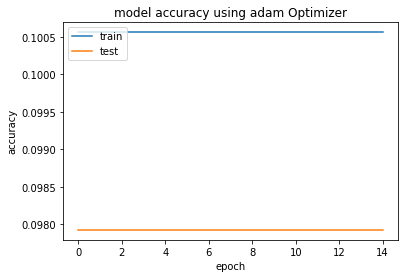

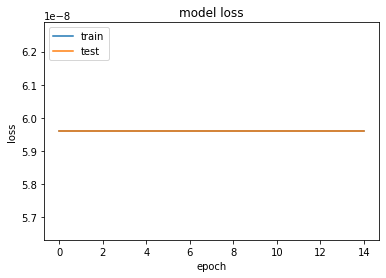

In [ ]:
import matplotlib.pyplot as plt
 
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy using adam Optimizer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Changing the train and test size as the accuracy is not great

Testing with triplet loss

In [10]:
##
!pip install sklearn
from sklearn.model_selection import train_test_split
(X_train_new,y_train_new),(X_test_new,y_test_new) = mnist.load_data()
X = np.concatenate((X_train_new,X_test_new),axis=0)
y = np.concatenate((y_train_new,y_test_new),axis=0)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7)

11493376/11490434 [==============================] - 0s 0us/step


In [11]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255
x_test = x_test / 255

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [12]:
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [20]:
rms = RMSprop()
triplet_loss = tfa.losses.TripletSemiHardLoss()
model.compile(loss=triplet_loss, optimizer=rms, metrics=["accuracy"])
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,batch_size=128,epochs=10,validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/10
689/689 [==============================] - 39s 8ms/step - loss: 0.9517 - accuracy: 0.3297 - val_loss: 0.7145 - val_accuracy: 0.4422
Epoch 2/10
689/689 [==============================] - 5s 7ms/step - loss: 0.6574 - accuracy: 0.4393 - val_loss: 0.5037 - val_accuracy: 0.4066
Epoch 3/10
689/689 [==============================] - 5s 7ms/step - loss: 0.5015 - accuracy: 0.3935 - val_loss: 0.4166 - val_accuracy: 0.3669
Epoch 4/10
689/689 [==============================] - 5s 7ms/step - loss: 0.4148 - accuracy: 0.3579 - val_loss: 0.3799 - val_accuracy: 0.3428
Epoch 5/10
689/689 [==============================] - 5s 7ms/step - loss: 0.3746 - accuracy: 0.3299 - val_loss: 0.3288 - val_accuracy: 0.3019
Epoch 6/10
689/689 [==============================] - 5s 7ms/step - loss: 0.3263 - accuracy: 0.3079 - val_loss: 0.2953 - val_accuracy: 0.2910
Epoch 7/10
689/689 [==============================] - 5s 7ms/step - loss: 0.3042 - accuracy: 0.2906 - val_loss: 0.2863 - val_accuracy: 0.2824
Epoch

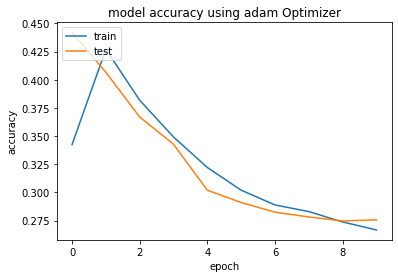

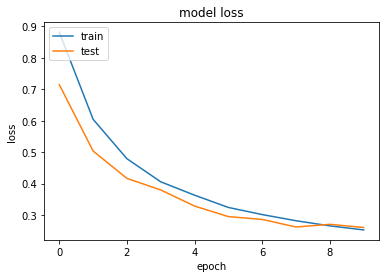

In [21]:
import matplotlib.pyplot as plt
 
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy using adam Optimizer')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
rms = Adam()
triplet_loss = tfa.losses.TripletSemiHardLoss()
model.compile(loss=triplet_loss, optimizer=rms, metrics=["accuracy"])
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,batch_size=128,epochs=10,validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Epoch 1/10
690/690 [==============================] - 6s 8ms/step - loss: 0.4112 - accuracy: 0.0645 - val_loss: 0.4634 - val_accuracy: 0.0796
Epoch 2/10
690/690 [==============================] - 5s 7ms/step - loss: 0.4163 - accuracy: 0.0653 - val_loss: 0.4615 - val_accuracy: 0.0797
Epoch 3/10
690/690 [==============================] - 5s 7ms/step - loss: 0.4107 - accuracy: 0.0653 - val_loss: 0.4609 - val_accuracy: 0.0767
Epoch 4/10
690/690 [==============================] - 5s 7ms/step - loss: 0.4067 - accuracy: 0.0635 - val_loss: 0.4605 - val_accuracy: 0.0787
Epoch 5/10
690/690 [==============================] - 5s 7ms/step - loss: 0.4101 - accuracy: 0.0651 - val_loss: 0.4552 - val_accuracy: 0.0762
Epoch 6/10
690/690 [==============================] - 5s 7ms/step - loss: 0.3975 - accuracy: 0.0629 - val_loss: 0.4538 - val_accuracy: 0.0821
Epoch 7/10
690/690 [==============================] - 5s 7ms/step - loss: 0.3899 - accuracy: 0.0624 - val_loss: 0.4577 - val_accuracy: 0.0757
Epoch 

The accuracy after splitting the data in 70:30 split is much worse than above . So I'm not doing it any further.

RMSprop is the best one because it has higher accuracy

Advantages of Siamese Network :- 

1] We can easily train a model if we have very less images belonging to one class.

2] It learns through learning embeddings which place same classes together . (Semantic Similarity)

Disadvantages of Siamese Network :-

1] Doesn't output probabilities.

2] Training time or siamese is more when compared to normal classification model.